In [1]:
# Import necessary libraries
import scipy as sp
import Model.IR_model as mm
from numpy import loadtxt, gradient
matplotlib.style.use('default')
import matplotlib.pyplot as plt
import numpy as np

# Load data from a CSV file
filename = 'partA/training1.csv'
data = loadtxt(filename, delimiter=',', skiprows=1)

# Split the data into columns
index, time, distance, velocity_command, raw_ir1, raw_ir2, raw_ir3, raw_ir4, \
    sonar1, sonar2 = data.T

# Perform data filtering using a custom function (sn1_model)
# This is the first filtering
sn1_x, sn1_v, sn1_fit, sn1_params = mm.remove_outlier(mm.sn1_model, distance, sonar1, 0.7)
print(sn1_params)

# Define a custom function sn1_model
def sn1_model(x, a, b, c):
    return a * (x + b) + c

# Fit the filtered data using the sn1_model and optimize.curve_fit
filtered_params, cov = sp.optimize.curve_fit(sn1_model, sn1_x, sn1_fit)
filtered_fit = sn1_model(sn1_x, *filtered_params)
print(filtered_params)

# Extract parameters from the fitted model
sn1_a = filtered_params[0]
sn1_b = filtered_params[1]
sn1_c = filtered_params[2]

h_sn1 = lambda x : sn1_a * (x + sn1_b) + sn1_c

# Define the inverse function H_INV_sn1
def H_INV_sn1(v):
    return (v - sn1_c) / sn1_a - sn1_b

# Create a plot to visualize the original data, filtered data, and fitted curve
# plt.figure(figsize=(12, 6))
# plt.plot(distance, sonar1, '.', alpha=0.2, label='Raw Data')
# plt.plot(sn1_x, sn1_v, '.', label='Processed Data')
# plt.plot(sn1_x, sn1_fit, '.', label='Fitted Data')
x_values = np.linspace(0, 4, 100)
# plt.plot(x_values, sn1_model(x_values, *filtered_params), label='Fitted Curve')

# # Add labels, legends, and title
# plt.xlabel('Distance')
# plt.ylabel('Sonar1 Sensor Values')
# plt.legend()
# plt.title('Sonar1 Sensor Data and Fitting')

# # Display the plot
# plt.show()
Error_SN1 = h_sn1(distance) - sonar1

[  0.82721749  19.34362126 -15.91513279]
[  0.97627199  30.98807107 -30.26798627]


# Likelihood

In [2]:
ir3_x, ir3_v, ir3_fit, ir3_params = mm.remove_outlier(mm.ir3_model, distance, raw_ir3, 3)
print(ir3_params)

# Extract parameters from the IR3 sensor fitting
a1_ir3 = ir3_params[0]
a2_ir3 = ir3_params[1]
b_ir3 = ir3_params[2]
c_ir3 = ir3_params[3]

# Define a lambda function h_ir3 for further calculations
h_ir3 = lambda x: a1_ir3 / (x + a2_ir3) + b_ir3 * x + c_ir3


Error_IR3 = h_ir3(distance) - raw_ir3




[ 0.28287159 -0.00737862  0.17192251  0.01669715]


In [3]:

# Remove outliers for IR4 sensor
ir4_x, ir4_v, ir4_fit, ir4_params = mm.remove_outlier(mm.ir4_model, distance, raw_ir4, 3)
print(ir4_params)

# Extract parameters from the IR4 sensor model
a1_ir4 = ir4_params[0]
b1_ir4 = ir4_params[1]
a2_ir4 = ir4_params[2]
b2_ir4 = ir4_params[3]
c1_ir4 = ir4_params[4]
c2_ir4 = ir4_params[5]
d1_ir4 = ir4_params[6]
d2_ir4 = ir4_params[7]
e1_ir4 = ir4_params[8]
e2_ir4 = ir4_params[9]
f_ir4 = ir4_params[10]

# Define a function h_ir4 based on the extracted parameters
h_ir4 = lambda x: (a1_ir4*(x+d1_ir4)**2 + b1_ir4*(x+e1_ir4) + c1_ir4) / (a2_ir4*(x+d2_ir4)**2 + b2_ir4*(x+e2_ir4) + c2_ir4) + f_ir4
Error_IR4 = h_ir4(distance) - raw_ir4

[ 0.48422691  0.82917612  2.52523815 -0.24964589 -0.88411261  1.35221757
  1.16210976 -0.26839409  0.24883824  3.59544757  1.20977716]


## liklihood function

In [4]:

def findIndex(needle, haystack):
    ind = 0
    for hay in haystack:
        if np.abs(hay - needle) < 1:
            return ind
        ind += 1
    print("#1",end = "")
    return None


fish = findIndex(2.5, distance)
print(fish)

731


In [5]:
import numpy as np

# Function to calculate the derivative of a given function 'func' at point 'x'
def diff(func, x):
    dx = 0.001
    return (func(x + dx) - func(x)) / dx

# Function to invert 'sensor_model' to find 'curguess' such that 'sensor_model(curguess)' is close to 'z'
def H_invert(sensor_model, z, scope=(0, 10)):
    half = (scope[1] - scope[0]) / 2
    curguess = scope[1] / 2
    lim = 0
    maxLim = 1000
    
    while (np.abs(sensor_model(curguess) - z) > 0.0001 and lim < maxLim):
        lim += 1
        if sensor_model(curguess) > z:
            if diff(sensor_model, curguess) > 0:  # If positive slope
                curguess -= half / 2
            else:
                curguess += half / 2
        else:
            if diff(sensor_model, curguess) > 0:  # If positive slope
                curguess += half / 2
            else:
                curguess -= half / 2
        half /= 2

    if np.abs(sensor_model(curguess) - z) > 0.0001:
        return None
    else:
        return curguess

# Function to find two guesses using 'invertH' within specified range 'scope'
def amb_H_invert(sensor_model, z, mid, scope=(0, 4)):
    guess = H_invert(sensor_model, z, scope=(0, mid))
    guess2 = H_invert(sensor_model, z, scope=(mid, 4))
    return guess, guess2

In [6]:
# Set the current 'z' value or target value

Vol_z = 3  # Use a specific value of 'z'
# H_sensor_model = H_INV_sn1# Use the 'h_ir4' sensor model
# print(H_sensor_model)

# # Calculate two guesses ('gus1' and 'gus2') for the inversion of 'H_sensor_model' at 'cur_z'
# gPoint1, gPoint2 = amb_H_invert(H_sensor_model, Vol_z, mid=1)
# # print(gus1)

# # Create a figure for plotting
# plt.figure(figsize=(10, 10))
# # plt.figure(figsize=(4, 3), dpi=150)

# # Plot the original data points for IR4 with a label
# plt.plot(distance, sonar1, '.', alpha=0.2, label='Original Data')

# # Plot the curve generated by 'H_sensor_model' with a label
# plt.plot(distance, H_sensor_model(distance), '-', label='IR4 sensor model line')

# # Plot the guessed points ('gus1' and 'gus2') on the curve with labels and larger markers
# try:
#     plt.plot(gPoint1, H_sensor_model(gPoint1), '-bo', markersize=10, label='Guess Point 1')
#     print(gPoint1)
#     print(H_sensor_model(gPoint1))
# except:
#     pass

# try:
#     plt.plot(gPoint2, H_sensor_model(gPoint2), '-yo', markersize=10, label='Guess Point 2')
#     print(gPoint2)
#     print(H_sensor_model(gPoint2))
# except:
#     pass

# # Add labels for the x-axis and y-axis
# plt.xlabel("Distance")
# plt.ylabel("Voltage")

# # Add a legend
# plt.legend()



In [7]:
def VarError_LookUpTable(x, error, xstep=0.3):
    """
    Calculate the mean and variance of error values based on a lookup table.

    Args:
        x (array): Array of lengths.
        error (array): Array of fitting curve error values.
        xstep (float): Step size for partitioning the data. Defaults to 0.1.

    Returns:
        tuple: Three arrays containing x-axis values, mean error values, and variance of error values.
    """
    x_now = xstep
    curbar = np.array([])

    x_mu = np.array([])
    std_x = np.array([])
    xaxis = np.array([])

    for i in range(0, len(x)):
        
        if (x[i] < x_now):
            
            curbar = np.append(curbar, error[i])
        else:
            error_std = np.std(curbar)
            error_mean = np.mean(curbar)
            x_mu = np.append(x_mu, error_mean)
            std_x = np.append(std_x, error_std)
            xaxis = np.append(xaxis, x[i])
            curbar = np.array([])
            x_now += xstep
    
    return xaxis, x_mu, std_x


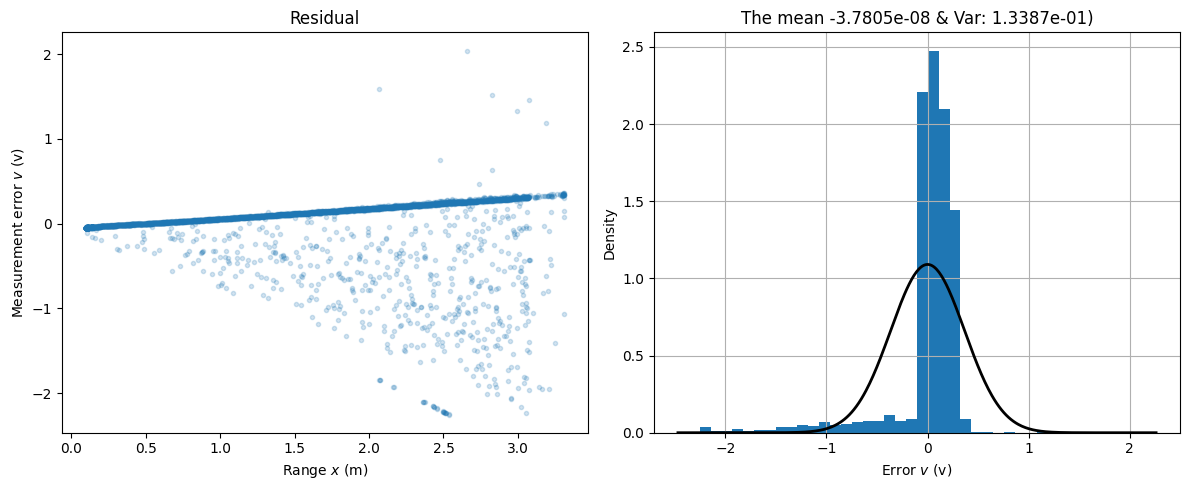

[  0.82721749  19.34362126 -15.91513279]


In [8]:
import Model.IR_model as mm
sn1_x, sn1_v,sn1_fit,sn1_params= mm.remove_outlier(mm.sn1_model,distance,sonar1,3)
sn1_mu, sn1_std,sn1_error = mm.Residual_and_Histogram(sn1_x,sn1_v,sn1_fit)




# err = 
print(sn1_params)

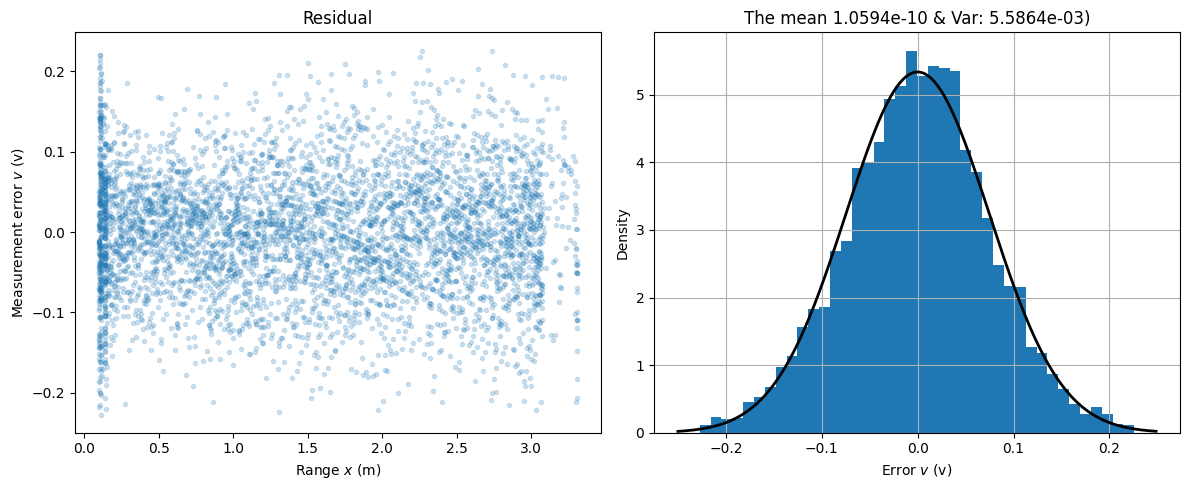

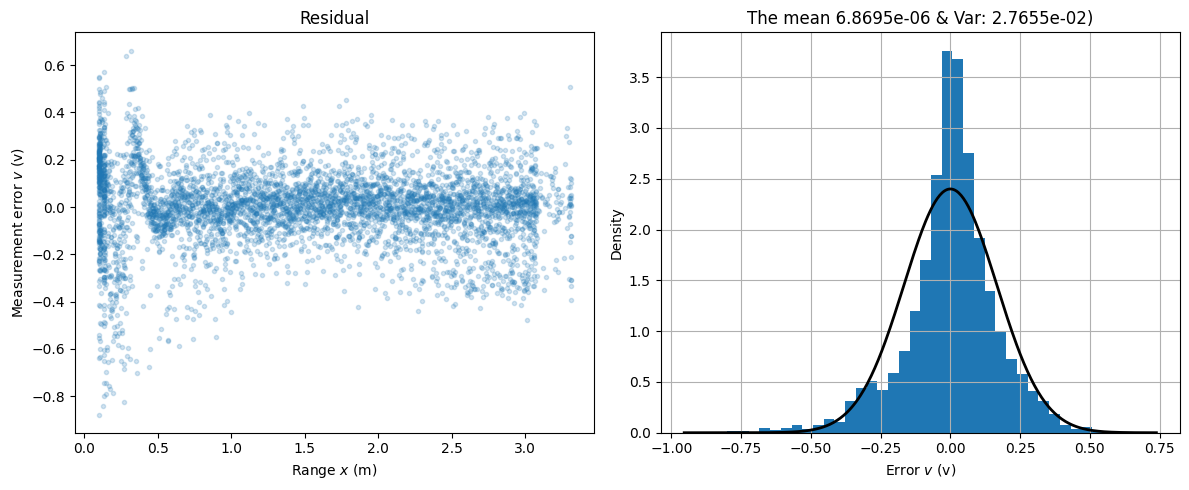

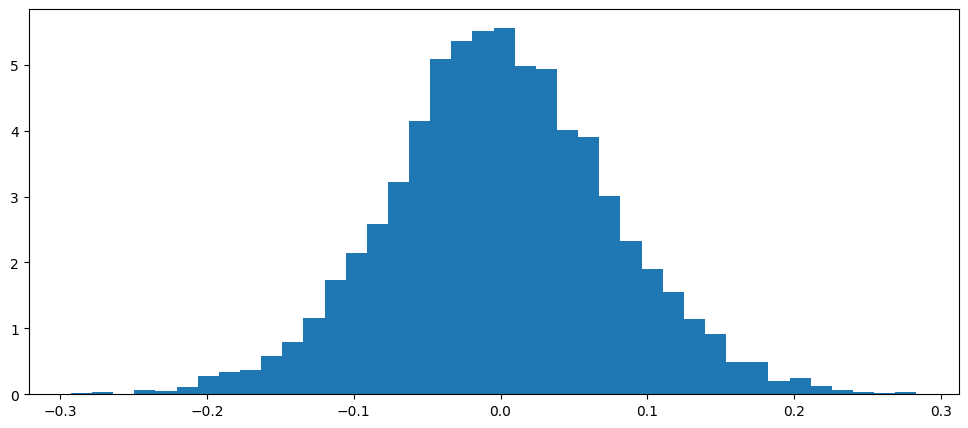

In [9]:
import Model.IR_model as mm
ir3_x, ir3_v,ir3_fit,ir3_params= mm.remove_outlier(mm.ir3_model,distance,raw_ir3,3)
ir3_mu, ir3_std,ERR_ir3 = mm.Residual_and_Histogram(ir3_x,ir3_v,ir3_fit)

# import Model.IR_model as mm
ir4_x, ir4_v,ir4_fit,ir4_params= mm.remove_outlier(mm.ir4_model,distance,raw_ir4,3)
ir4_mu, ir4_std,ERR_ir4 = mm.Residual_and_Histogram(ir4_x,ir4_v,ir4_fit)
# ERR_sn1 = sonar1 - sn1_model(distance, *filtered_params


import matplotlib.pyplot as plt  # Import the necessary module
from scipy.stats import norm
fig, ax = plt.subplots(figsize=(12, 5))  # Specify figsize
ax.hist(Error_IR3, bins=40, density=True)
mu,std = norm.fit(Error_IR3)

In [10]:
Xaxis_sn1, Mu_X_sn1, std_X_sn1 = VarError_LookUpTable(distance,Error_SN1,0.3)
# ''' Input: x, error, step  '''
Xaxis_ir3, Mu_X_ir3, std_X_ir3 = VarError_LookUpTable(distance,Error_IR3,0.3)
Xaxis_ir4, Mu_X_ir4, std_X_ir4 = VarError_LookUpTable(distance,Error_IR4,0.3)
# plt.figure()
# plt.plot(Xaxis_ir3,Mu_X_ir3)
# plt.plot(Xaxis_ir3,std_X_ir3)
# print(Xaxis_sn1)

ir4 1 guess 1.471923828125
0.793456733893046
-1


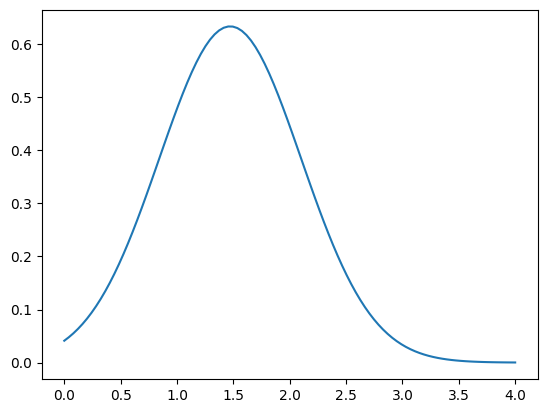

In [11]:
from scipy import stats
# gPoint2, gPoint1 = amb_H_invert(H_sensor_model, Vol_z, mid=1)
g_sn1 = H_invert(h_sn1, sonar1[fish], scope=(1, 4))

def find_std_index(value, intervals):
    if value < intervals[0]:
        return 0
    if value >= intervals[-1]:
        return len(intervals) - 1
    for i in range(len(intervals) - 1):
        if value >= intervals[i] and value < intervals[i ]:
            return i
    return -1  # 如果值不在任何区间内，则返回-1


g_sn1_Point_index = find_std_index(g_sn1, Xaxis_sn1)
g_sn1_Point_std = std_X_sn1[g_sn1_Point_index]



# Debug section
if not g_sn1 is None:
    L_sn1 = stats.norm.pdf(x_values, loc=g_sn1, scale=(g_sn1_Point_std)**2)
    print(f"ir4 1 guess {g_sn1}")
    sn1Plot = plt.plot(x_values, L_sn1)
else:
    sn1Plot = plt.plot()


print(g_sn1_Point_std)
print(g_sn1_Point_index)

In [12]:
# import numpy as np

# def gaussian(x, mu, sigma):
#     """
#     Calculate the value of the Gaussian function at a given x.

#     Parameters:
#     - x: Input value
#     - mu: Mean of the Gaussian distribution
#     - sigma: Standard deviation of the Gaussian distribution

#     Returns:
#     - The value of the Gaussian function at x
#     """
#     coefficient = 1 / (sigma * np.sqrt(2 * np.pi))
#     exponent = -((x - mu) ** 2) / (2 * sigma ** 2)
#     return coefficient * np.exp(exponent)


# gaussian_values = gaussian(x_values,g_sn1,gPoint_std)
# # Print or use the Gaussian values as needed
# print(gaussian_values)
# plt.plot(gaussian_values)


0.552734375
3.025390625
ir3 1 guess 0.552734375
ir3 2 guess 3.025390625


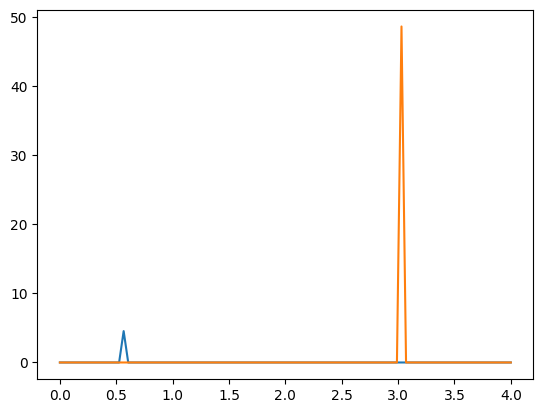

In [13]:
g_ir3_1, g_ir3_2= amb_H_invert(h_ir3, raw_ir3[fish], mid=1)

print(g_ir3_1)
print(g_ir3_2)

# Debug section
if not g_ir3_1 is None:
    g_ir31_index = find_std_index(g_ir3_1, Xaxis_ir3)
    g_ir31_std = std_X_ir3[g_ir31_index]
    L_ir31= stats.norm.pdf(x_values, loc=g_ir3_1, scale=(g_ir31_std)**2)
    print(f"ir3 1 guess {g_ir3_1}")
    ir31_Plot = plt.plot(x_values, L_ir31)
else:
    ir31_Plot = plt.plot()
    
if not g_ir3_2 is None:
    g_ir32_index = find_std_index(g_ir3_2, Xaxis_ir3)
    g_ir32_std = std_X_ir3[g_ir32_index]
    L_ir32 = stats.norm.pdf(x_values, loc=g_ir3_2, scale=(g_ir32_std)**2)
    print(f"ir3 2 guess {g_ir3_2}")
    ir32_Plot = plt.plot(x_values, L_ir32)
else:
    ir32_Plot = plt.plot()

ir4 1 guess 0.22866210937499992
ir4 2 guess 1.375579833984375
0.22866210937499992
1.375579833984375


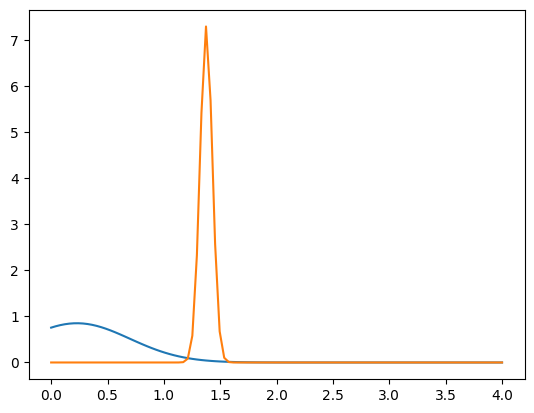

In [14]:
g_ir4_Point1, g_ir4_Point2 = amb_H_invert(h_ir4, raw_ir4[fish], mid=0.3)



# Debug section
if not g_ir4_Point1 is None:
    g_ir4_Point1_index = find_std_index(g_ir4_Point1, Xaxis_ir4)
    gPoint1_std = std_X_ir4[g_ir4_Point1_index]
    L_ir41 = stats.norm.pdf(x_values, loc=g_ir4_Point1, scale=(gPoint1_std))
    print(f"ir4 1 guess {g_ir4_Point1}")
    ir41Plot = plt.plot(x_values, L_ir41)
else:
    ir41Plot = plt.plot()

if not g_ir4_Point2 is None:
    g_ir4_Point2_index = find_std_index(g_ir4_Point2, Xaxis_ir4)
    gPoint2_std = std_X_ir4[g_ir4_Point2_index]
    L_ir42 = stats.norm.pdf(x_values, loc=g_ir4_Point2, scale=(gPoint2_std)**2)
    print(f"ir4 2 guess {g_ir4_Point2}")
    ir42Plot = plt.plot(x_values, L_ir42)
else:
    ir42Plot = plt.plot()
    
    
print(g_ir4_Point1)
print(g_ir4_Point2)

# Total likelihood 

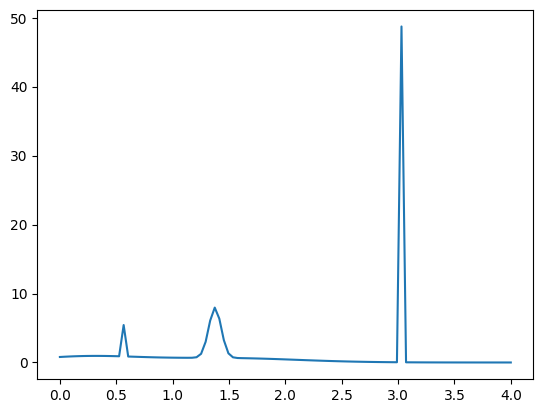

In [15]:
L_Vol = L_sn1;
L_Vol += L_ir31;
L_Vol += L_ir32;
L_Vol += L_ir41;
L_Vol += L_ir42;

plt.plot(x_values,L_Vol)

# BLUE 

In [16]:
# import data
import numpy as np
train1 = np.loadtxt('partA/training2.csv', delimiter=',', skiprows=1, usecols = (1,2,3))
# train1 = np.loadtxt('partA/test.csv', delimiter=',', skiprows=1, usecols = (1,2,3))

time_t1, range_t1, velocity_command_t1= train1.T

# rename the data variable
v_com = velocity_command_t1
z = range_t1 
t = time_t1
dt = 0.01

g = lambda x_prev, u, dt: u * dt

W = lambda x_now, x_prev, u_prev, dt: x_now - x_prev - g(x_prev, u_prev, dt)
X_now = lambda x_prev, u_prev, dt: x_prev + g(x_prev, u_prev, dt) #+ Wcur

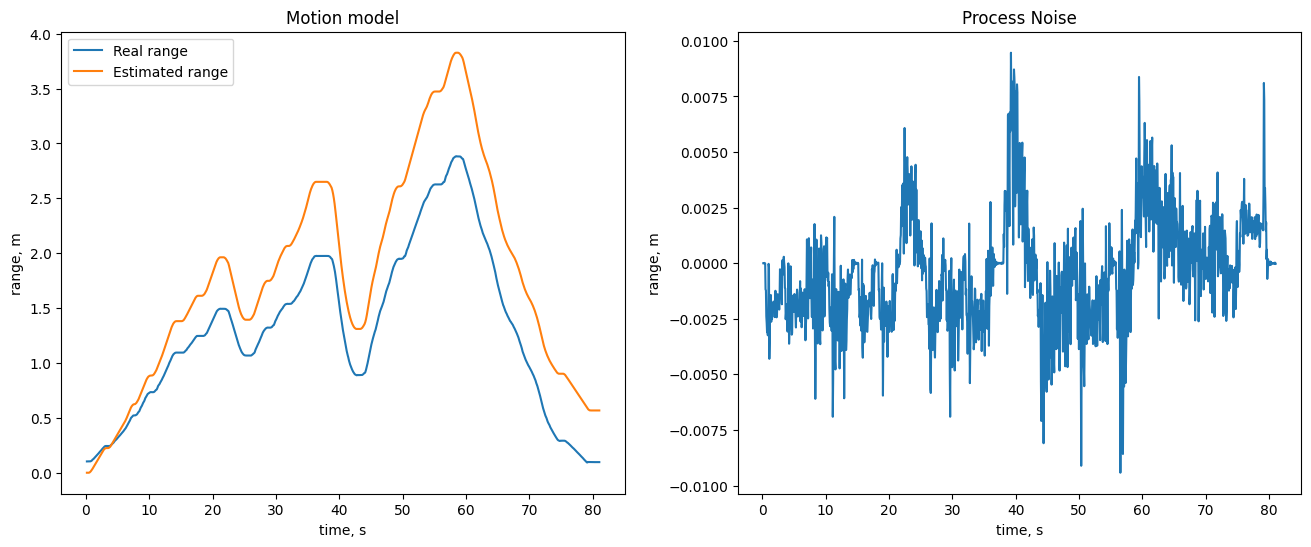

In [17]:
# %%
# plt.plot(time, velocity_command)
import numpy as np
import matplotlib.pyplot as plt

data1 =  np.loadtxt('partA/training2.csv', delimiter=',', skiprows=1, usecols = (1,2,3))
time_, range__, velocity_command_= data1.T

command = velocity_command_
truex = range__
t = time_

x_estimate = np.array([0])
x_now = 0
#process noise
w_all = np.array([0])

for i in range(1, len(t)):
    dt = t[i] - t [i-1]
    x_now = X_now(x_now, command[i-1], dt   )#   , W(x_estimate[i-1], command[i-1], dt))
    w_cur = truex[i] - truex[i-1]-  g(x_estimate[i-1], command[i-1], dt)
    w_all = np.append(w_all, w_cur)
    x_estimate = np.append(x_estimate, x_now)


plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(t, truex)
plt.plot(t, x_estimate)
all_w = np.cumsum((w_all),dtype=float)

# for i in range(0, len(w_all)):
#     x_estimate[i] += all_w[i]
x_estimate += all_w

# plt.plot(t, x_estimate)

plt.legend(["Real range", "Estimated range", " "])
plt.title("Motion model")
plt.xlabel("time, s")
plt.ylabel("range, m")

plt.subplot(122)
# plt.plot(t,  x_estimate - truex -w_all)
plt.plot(t,  w_all)

plt.xlabel("time, s")
plt.ylabel("range, m")
plt.title("Process Noise")
del range__
del velocity_command_
del data1

In [18]:
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt

# Initial position
x_est = np.array([0])
x_now = 0
# process noise W
w_List = np.array([0])

for i in range(1,len(t)):
    dt = t[i] - t[i-1]
    x_now += g(v_com[i-1],dt) 
    # w_now = z[i] - z[i-1] - g(x_est[i-1],v_com[i-1],dt) -x_now
    w_now = z[i]- z[i-1] - g(v_com[i-1],dt)
    w_List = np.append(w_List,w_now)
    x_est = np.append(x_est,x_now)


fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Specify figsize
# ax[0].figure()
# ax.subplot()

# all_w = np.cumsum((w_List),dtype=float)

# x_est += all_w

# plt.subplot(122)
ax[1].plot(t, w_List) 
# ax[1].plot(t, x_est)



# *********************** plot Motion Model & Process Noise ******************************************
# plot motion model
ax[0].plot(t, z)
ax[0].plot(t, x_est)
ax[0].set_title("Motion Model")
ax[0].set_xlabel(r"time (s)")
ax[0].set_ylabel(r"position (m)")

# plot process noise
ax[1].plot(t, w_List) 
ax[1].set_title("Process Noise")
ax[1].set_xlabel(r"time (s)")
ax[1].set_ylabel(r"position (m)")
ax[1].grid()

# plt.tight_layout()  # Adjust layout
# plt.show()  # Display the plots



TypeError: <lambda>() missing 1 required positional argument: 'dt'

In [20]:
import numpy as np
train1 = np.loadtxt('partA/training2.csv', delimiter=',', skiprows=1, usecols = (1,2,3))
# train1 = np.loadtxt('partA/test.csv', delimiter=',', skiprows=1, usecols = (1,2,3))

time_t1, range_t1, velocity_command_t1= train1.T

# rename the data variable
v_com = velocity_command_t1
z = range_t1 
t = time_t1




t = 264
print(range_t1[t])


totalvar = 0
topsum = 0
g_sonar = H_invert(h_sn1, 2)
varsn1 = std_X_sn1[find_std_index(g_sonar, Xaxis_sn1)] ** 2

topsum += g_sonar/varsn1
totalvar += 1/varsn1

g_1ir3, g_2ir3 = amb_H_invert(h_ir3, raw_ir3[t], mid=1)
if (not g_1ir3 == None):
    varir31 = std_X_ir3[find_std_index(g_1ir3, Xaxis_ir3)] ** 2
    topsum += g_1ir3/varir31
    totalvar += 1/varir31

if (not g_2ir3 == None):
    varir32 = std_X_ir3[find_std_index(g_2ir3, Xaxis_ir3)] ** 2
    topsum += g_2ir3/varir32
    totalvar += 1/varir32

g_1ir4, g_2ir4 = amb_H_invert(h_ir4, raw_ir4[t], mid=0.44)
if (not g_1ir4 == None):
    varir41 = std_X_ir4[find_std_index(g_1ir4, Xaxis_ir4)]
    topsum += g_1ir4/varir41
    totalvar += 1/varir41
if (not g_2ir4 == None):
    varir42 = std_X_ir4[find_std_index(g_2ir4, Xaxis_ir4)]
    topsum += g_2ir4/varir42
    totalvar += 1/varir42


g_blue = topsum / totalvar
print(g_blue)

# varsn1
totalvar

1.1293332929298636
0.4185585808682541


188.07165794075064

In [21]:
# Load data
filename = 'partA/training1.csv'
data = loadtxt(filename, delimiter=',', skiprows=1)

# Split into columns
index, time, distance, velocity_command, raw_ir1, raw_ir2, raw_ir3, raw_ir4, \
    sonar1, sonar2 = data.T


In [22]:
# # *********************************     TRAINING 2      ************************************
# Load data
filename = 'partA/training2.csv'
data = loadtxt(filename, delimiter=',', skiprows=1)

# Split into columns
index, time, distance, velocity_command, raw_ir1, raw_ir2, raw_ir3, raw_ir4, \
    sonar1, sonar2 = data.T


In [23]:

dt = 0.01

g = lambda x_prev, u, dt: u * dt

W = lambda x_now, x_prev, u_prev, dt: x_now - x_prev - g(x_prev, u_prev, dt)
X_now = lambda x_prev, u_prev, dt: x_prev + g(x_prev, u_prev, dt) #+ Wcur
w_var = np.var(w_List)

In [24]:
print(velocity_command)
print(g_blue)

[-0. -0. -0. ... -0. -0. -0.]
0.4185585808682541


t=0t=100t=200t=300t=400t=500t=600t=700t=800t=900t=1000t=1100t=1200t=1300

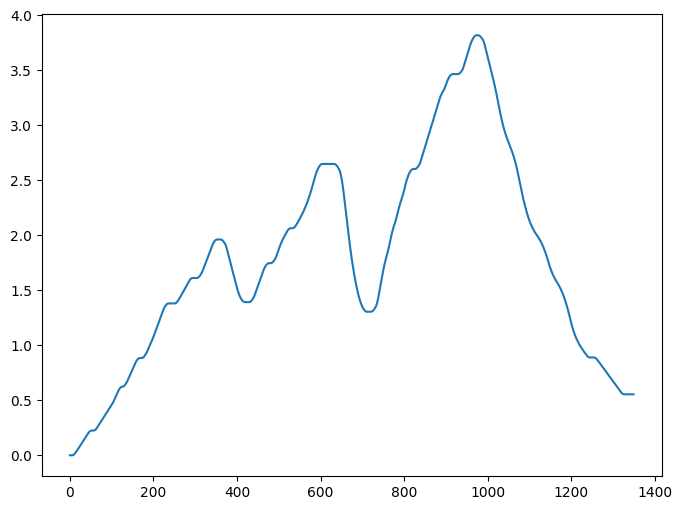

In [25]:

range_est = np.array([])
dt = 0.06
g_blue = 0

 

x_estimate = np.array([0])
x_now = 0

tooFar = 0.3
theend = len(time)-1
for t in range(0, theend): #len(time)
    if (np.mod(t, 100) == 0) :
        print(f"t={t}", end = "")


    totalvar = 0
    topsum = 0

    x_now = x_now + velocity_command[t-1] *  dt #   , W(x_estimate[i-1], command[i-1], dt))

    # print(x_now)
    
    x_estimate = np.append(x_estimate, x_now)

    # if not np.isnan(x_now):
    #     cur_w_var = w_var/(velocity_command[t])**2

    #     topsum += x_now/cur_w_var
    #     totalvar += 1/cur_w_var
    #     
    
    if (not g_sonar == None and np.abs(g_blue - g_sonar) < tooFar):
        g_sonar= H_invert(h_sn1, sonar1[t])
        varsn1 = std_X_sn1[find_std_index(g_sonar, Xaxis_sn1)]
        g_blue = g_sonar
    


    # g_sonar= H_invert(h_sn1, sonar1[t])
    # # print("g+sonar", g_sonar)
    # # varsn1 = var_x_sn1[findIndex2(g_sonar, Xaxis_sn1)]
    # # varsn1 = std_X_sn1[find_std_index(g_sonar, Xaxis_sn1)] 
    # varsn1 = 0.8

    # if (np.abs(g_blue - g_sonar) < tooFar):
    #     topsum += g_sonar/varsn1
    #     totalvar += 1/varsn1


    # # g_1ir3, g_2ir3 = ambInvertH(h_ir3, raw_ir3[t], mid=1)      
    # g_1ir3, g_2ir3 = amb_H_invert(h_ir3, raw_ir3[t], mid=1)      
    # if (not g_1ir3 == None and np.abs(g_blue - g_1ir3) < tooFar):
    #     # varir31 = var_x_ir3[findIndex2(g_1ir3, xaxis_ir3)]
    #     v_varir31 = std_X_ir3[find_std_index(g_1ir3,Xaxis_ir3)] 
    #     varir31 = v_varir31 / (diff(h_ir3, g_1ir3))**2
    #     # varir31 = 0.5
    #     topsum += g_1ir3/varir31
    #     totalvar += 1/varir31

    # if (not g_2ir3 == None and np.abs(g_blue - g_2ir3) < tooFar):
    #     # varir32 = var_x_ir3[findIndex2(g_2ir3, xaxis_ir3)]
    #     v_varir32 = std_X_ir3[find_std_index(g_2ir3,Xaxis_ir3)] 
    #     varir32 = v_varir32/ (diff(h_ir3, g_2ir3))**2
    #     # varir32 = 0.5
    #     topsum += g_2ir3/varir32
    #     totalvar += 1/varir32


    # # g_1ir4, g_2ir4 = amb_H_invert(h_ir4, raw_ir4[t], mid=0.44)
    # g_1ir4, g_2ir4 = amb_H_invert(h_ir4, raw_ir4[t], mid=0.44)
    # # print(g_1ir4,g_2ir4)

    # if (not g_1ir4 == None and np.abs(g_blue - g_1ir4) < tooFar):
    #     v_varir41 = ERR_ir4
    #     varir41 = v_varir41 / (diff(h_ir4, g_1ir4))**2
    #     topsum += g_1ir4/varir41
    #     totalvar += 1/varir41
        
    # if (not g_2ir4 == None and np.abs(g_blue - g_2ir4) < tooFar):
    #     v_varir42 = ERR_ir4
    #     varir42 = v_varir42 / (diff(h_ir4, g_2ir4))**2
    #     topsum += g_2ir4/varir42

    #     totalvar += 1/varir42
    # # if (totalvar != 0):
    #     g_blue = topsum / totalvar
    # # else:
        # print("hmm", end="")
    
    range_est = np.append(range_est, g_blue)



    # print(g_blue)

plt.figure(figsize=(8,6) )
plt.plot(x_estimate)
plt.plot(g_blue)
# print(time[theend])

In [26]:

    # return g_blue

# 使用示例
# g_blue = 0  # 初始化 g_blue
# g_2ir3 = 10  # 一个示例非 None 的值

# g_blue = (g_blue, g_2ir3)
print(g_blue)  # 输出 g_blue

0


### TEST

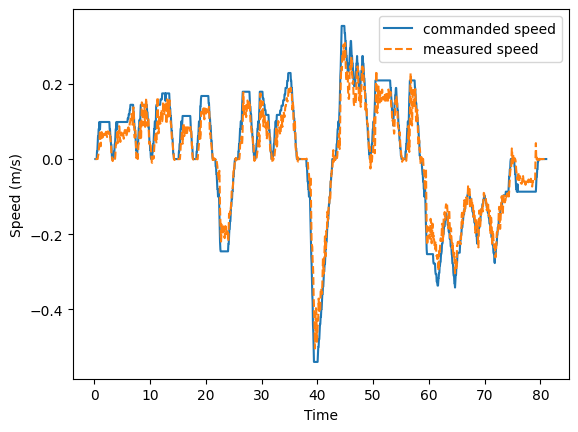

In [27]:
from numpy import loadtxt, gradient
matplotlib.style.use('default')
from matplotlib.pyplot import subplots, show

# Load data
filename = 'partA/training2.csv'
data = loadtxt(filename, delimiter=',', skiprows=1)

# Split into columns
index, time, distance, velocity_command, raw_ir1, raw_ir2, raw_ir3, raw_ir4, \
    sonar1, sonar2 = data.T

v_com = velocity_command

dt = time[1:] - time[0:-1]
v_est = gradient(distance, time)

fig, axes = subplots(1)
axes.plot(time, v_com, label='commanded speed')
axes.plot(time, v_est,'--', label='measured speed')
axes.set_xlabel('Time')
axes.set_ylabel('Speed (m/s)')
axes.legend()

show()

In [28]:
g = lambda u_prev, dt :  u_prev * dt


import numpy as np
train1 = np.loadtxt('partA/training2.csv', delimiter=',', skiprows=1, usecols = (1,2,3))
# train1 = np.loadtxt('partA/test.csv', delimiter=',', skiprows=1, usecols = (1,2,3))

time_t1, range_t1, velocity_command_t1= train1.T

# rename the data variable
v_com = velocity_command_t1
z = range_t1 
t = time_t1

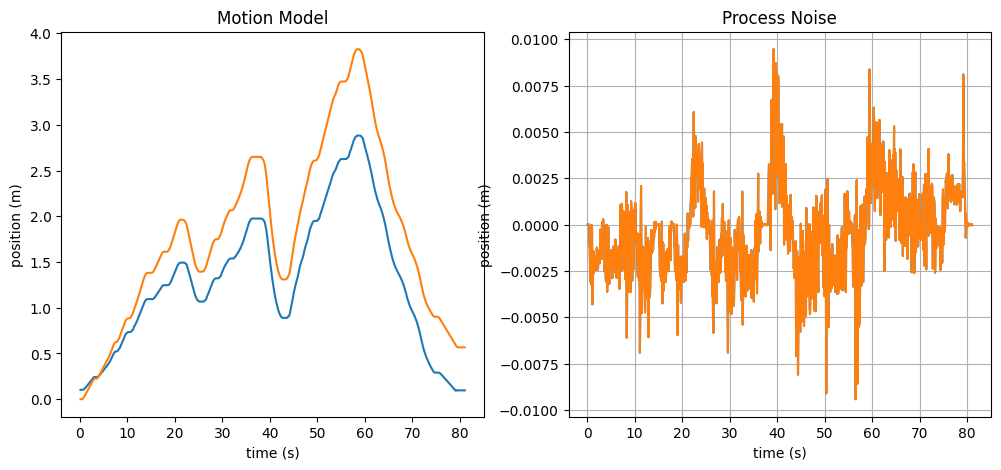

In [29]:
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt

# Initial position
x_est = np.array([0])
x_now = 0
# process noise W
w_List = np.array([0])

for i in range(1,len(t)):
    dt = t[i] - t[i-1]
    x_now += g(v_com[i-1],dt) 
    # w_now = z[i] - z[i-1] - g(x_est[i-1],v_com[i-1],dt) -x_now
    w_now = z[i]- z[i-1] - g(v_com[i-1],dt)
    w_List = np.append(w_List,w_now)
    x_est = np.append(x_est,x_now)


fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Specify figsize
# ax[0].figure()
# ax.subplot()

# all_w = np.cumsum((w_List),dtype=float)

# x_est += all_w

# plt.subplot(122)
ax[1].plot(t, w_List) 
# ax[1].plot(t, x_est)



# *********************** plot Motion Model & Process Noise ******************************************
# plot motion model
ax[0].plot(t, z)
ax[0].plot(t, x_est)
ax[0].set_title("Motion Model")
ax[0].set_xlabel(r"time (s)")
ax[0].set_ylabel(r"position (m)")

# plot process noise
ax[1].plot(t, w_List) 
ax[1].set_title("Process Noise")
ax[1].set_xlabel(r"time (s)")
ax[1].set_ylabel(r"position (m)")
ax[1].grid()

In [30]:
# w_List
w_var = np.var(w_List)
print(w_var)


    # if not np.isnan(x_now):
    #     cur_w_var = w_var/(velocity_command[t])**2

    #     topsum += x_now/cur_w_var
    #     totalvar += 1/cur_w_var

6.109198241562598e-06


t=0t=100t=200hmmhmmhmmt=300hmmhmmhmmhmmhmmhmmt=400hmmhmmhmmt=500hmmhmmhmmhmmhmmhmmhmmhmmhmmt=600hmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmt=700hmmhmmhmmt=800hmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmt=900hmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmt=1000hmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmhmmt=1100hmmhmmhmmhmmt=1200hmmt=1300

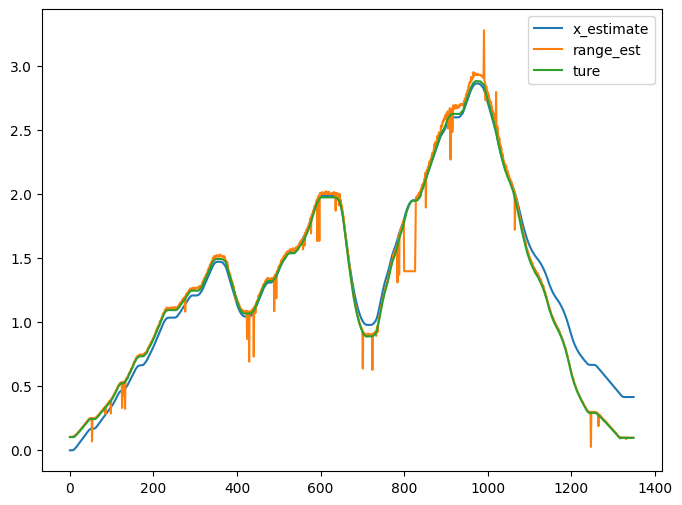

In [32]:

range_est = np.array([])
dt = 0.045

g_blue = 0

 

x_estimate = np.array([0])
x_now = 0

tooFar = 0.07
theend = len(time)-1
for t in range(0, theend): #len(time)
    if (np.mod(t, 100) == 0) :
        print(f"t={t}", end = "")




    totalvar = 0
    topsum = 0

    x_now = x_now + velocity_command[t-1] *  dt #   , W(x_estimate[i-1], command[i-1], dt))
    
    x_estimate = np.append(x_estimate, x_now) 
    
    
# ***********************************************************************
    # if not np.isnan(x_now):
    #     cur_w_var = w_var/(velocity_command[t]) ** 2

    #     topsum += x_now/cur_w_var
    #     totalvar += 1/cur_w_var
# # ***********************************************************************
    g_sonar= H_invert(h_sn1, sonar1[t])
    varsn1 = std_X_sn1[find_std_index(g_sonar, Xaxis_sn1)] ** 2 
    if ( np.abs(g_blue - g_sonar) < 0.4 ):
      
        g_blue = g_sonar
        
        topsum += g_sonar/varsn1
        totalvar += 1/varsn1

# # # # ***********************************************************************
#     g_1ir3, g_2ir3 = amb_H_invert(h_ir3, raw_ir3[t], mid=1)      

#     if (not g_1ir3 == None and np.abs(g_blue - g_1ir3) <  0.4):
#         v_varir31 = std_X_ir3[find_std_index(g_1ir3,Xaxis_ir3)] ** 2
#         topsum += g_1ir3/v_varir31
#         totalvar += 1/v_varir31
#     if (not g_2ir3 == None and np.abs(g_blue - g_2ir3) < 0.4):
#         # varir32 = var_x_ir3[findIndex2(g_2ir3, xaxis_ir3)]
#         v_varir32 = std_X_ir3[find_std_index(g_2ir3,Xaxis_ir3)] ** 2 
#         topsum += g_2ir3/v_varir32
#         totalvar += 1/v_varir32


# # ***********************************************************************
#     g_1ir4, g_2ir4 = amb_H_invert(h_ir4, raw_ir4[t], mid=1)      

#     if (not g_1ir4 == None and np.abs(g_blue - g_1ir4) < 0.4):
#         v_varir41 = std_X_ir4[find_std_index(g_1ir4,Xaxis_ir4)] ** 2 
#         topsum += g_1ir4/v_varir41
#         totalvar += 1/v_varir41
#     if (not g_2ir4 == None and np.abs(g_blue - g_2ir4) < 0.4):
#         # varir32 = var_x_ir3[findIndex2(g_2ir3, xaxis_ir3)]
#         v_varir42 = std_X_ir4[find_std_index(g_2ir4,Xaxis_ir4)] ** 2 
#         topsum += g_2ir4/v_varir42
#         totalvar += 1/v_varir42
    
    
    
    if (totalvar != 0):
        g_blue = topsum / totalvar
    else:
        print("hmm", end="")


    
    range_est = np.append(range_est, g_blue)



    # print(g_blue)
plt.figure(figsize=(8, 6))
plt.plot(x_estimate, label='x_estimate')  # 添加 x_estimate 曲线，并标记为 'x_estimate'
plt.plot(range_est,  label='range_est')  # 添加 range_est 曲线，并标记为 'range_est'，使用 '.' 表示点状图
plt.plot(z, label='ture')  # 添加 z 曲线，并标记为 'z'
plt.legend()
# print(time[theend])
# really good
